
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_amarillo@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio A/B Testing Parametrico


#### Ejercicio 1:  Linea de montaje 

En una fabrica de componenetes textil se quiere comparar el tiempo de fabricacion de un determinado producto mediante tres métodos diferentes.  Se seleccionan aleatoriamente productos elaborados con cada uno de los métodos y se observa el tiempo de fabricación. 


1. ¿Se verifican los supuestos del modelo de análisis de la varianza?

2. ¿Existe evidencia de que el método influye en el tiempo medio de elaboración del producto?

3. La empresa valora que el tiempo de fabricación sea el menor posible. ¿Qué método cree que ofrece mejores resultados?

_______________________________

1. **Ojetivo**: Se desea comprarar el tiempo de fabricación de un determinado producto en tres métodos diferentes y ver si el método influye en el tiempo medio de elaboración del producto y cual es el menor.

2. **Hipótesis**: 

    - H0 : el tiempo medio de elaboración no cambia.
    - H1 : El tiempo medio de elboración cambia de forma significativa.

3. **Exploración de los datos y asunciones**

In [75]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath('../'))
from src import soporte_abtesting as sa


In [76]:
df = pd.read_csv("../datos/linea_montaje.csv")
df

,minutos,metodo
0,4.166484,A
1,4.887466,A
2,0.727608,A
3,8.280542,A
4,1.413129,A
...,...,...
145,7.441723,C
146,9.085186,C
147,4.641973,C
148,6.892396,C


Hagamos una pequeña exploración:

In [77]:
sa.exploracion_dataframe(df, "metodo")

El número de datos es 150 y el de columnas es 2

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
minutos,float64
metodo,object



 ..................... 

Los valores que tenemos para las columnas categóricas son: 

 ..................... 

Los principales estadísticos de las columnas categóricas para el A son: 


,count,unique,top,freq
metodo,50,1,A,50



 ..................... 

Los principales estadísticos de las columnas numéricas para el A son: 


,count,mean,std,min,25%,50%,75%,max
minutos,50.0,4.720512,2.102454,0.130465,3.312806,4.690071,6.005251,9.584416



 ..................... 

Los principales estadísticos de las columnas categóricas para el B son: 


,count,unique,top,freq
metodo,50,1,B,50



 ..................... 

Los principales estadísticos de las columnas numéricas para el B son: 


,count,mean,std,min,25%,50%,75%,max
minutos,50.0,4.364523,2.085242,-0.818899,3.597334,4.506685,5.825817,7.668974



 ..................... 

Los principales estadísticos de las columnas categóricas para el C son: 


,count,unique,top,freq
metodo,50,1,C,50



 ..................... 

Los principales estadísticos de las columnas numéricas para el C son: 


,count,mean,std,min,25%,50%,75%,max
minutos,50.0,5.600274,2.329937,1.334696,4.071824,5.064969,6.976655,12.059491


Nos hemos dado cuenta de que hay valores negativos, estos representan tiempo de espera de las máquinas ya que se han roto o ha ocurrido algún imprevisto.

In [78]:
df[df["minutos"]<0]

,minutos,metodo
76,-0.818899,B
99,-0.187206,B


Como son tiempos que aumentan el tiempo de produccuón del producto los añadimos:

In [79]:
df["minutos"] = df["minutos"].apply(lambda x: np.abs(x))
df[df["minutos"]<0]

,minutos,metodo


## Normalidad

Veamos si podemos aplicar un test paramétrico por lo que comprobamos las asunciones. La primera es comprobar la normalidad para cada distribución de cada grupo. Como tenemos más de 30 datos usaremos la Kolmogorov.

In [80]:
# Kolmogorov test
np.random.seed(42)

datos = df.groupby("metodo")["minutos"].agg(["mean", "std"])
datos
lista_grupos = list(df["metodo"].unique())

for i in range(datos.shape[0]):
    dist = np.random.normal(loc=datos.iloc[i,0], scale = datos.iloc[i,1], size = df.shape[0])
    res = stats.kstest(df[df["metodo"]==lista_grupos[i]]["minutos"], dist) #Quiero que me diga si es normal o no
    print(f"Kolmogorov del grupo {lista_grupos[i]}: {res}")

Kolmogorov del grupo A: KstestResult(statistic=np.float64(0.08), pvalue=np.float64(0.9636335871514038), statistic_location=np.float64(4.316081897487645), statistic_sign=np.int8(-1))
Kolmogorov del grupo B: KstestResult(statistic=np.float64(0.10666666666666667), pvalue=np.float64(0.7691743320392471), statistic_location=np.float64(3.525986831791158), statistic_sign=np.int8(-1))
Kolmogorov del grupo C: KstestResult(statistic=np.float64(0.14), pvalue=np.float64(0.4363535753309122), statistic_location=np.float64(4.996451763260352), statistic_sign=np.int8(1))


Como los tres p-valores son mayores de 0.05 que es nuestro umbral, las tres variables son normales.

## Homoceidad:

Veamos is tenemos que aplicar Levene o Barlett.

<Axes: ylabel='Count'>

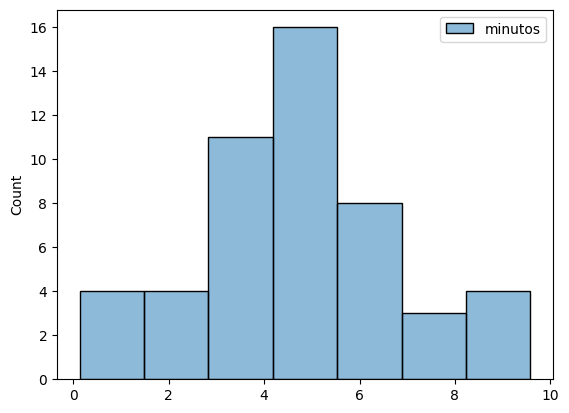

In [81]:
sns.histplot(df[df["metodo"]=="A"])

Como al ver ya la distribución del grupo A vemos que no es una normal perfecta, no necesitamos mirar las demás gráficas ya que necesitaremos aplicar Levene.

In [82]:
def calcular_levene(df, columna_grupos, columna_metrica):
    unicos = df[columna_grupos].unique()

    for grupo in unicos:
        df_metrica = df[df[columna_grupos] == grupo][columna_metrica]
        globals()[grupo] = df_metrica
    
    print(stats.levene(*[globals()[var] for var in unicos]))

calcular_levene(df, "metodo", "minutos")

LeveneResult(statistic=np.float64(0.6377981201955287), pvalue=np.float64(0.5299107034782387))


Vemos que el p-valor es 0.5 > 0.05 por lo que confirmamos la homoceidad.

Además, los datos son independientes, por lo tanto tendremos que aplicar un test paramétrico. Como tenemos tres grupos que comparar elegiremos Anova.

In [83]:
def calcular_anova(df, columna_grupos, columna_metrica):
    unicos = df[columna_grupos].unique()

    for grupo in unicos:
        df_metrica = df[df[columna_grupos] == grupo][columna_metrica]
        globals()[grupo] = df_metrica
    
    print(stats.f_oneway(*[globals()[var] for var in unicos]))

calcular_anova(df, "metodo", "minutos")

F_onewayResult(statistic=np.float64(4.160769025074968), pvalue=np.float64(0.017470102171365402))


Observamos que el p-valor es 0.01<0.05 por lo que sí que hay una diferencia significativa entre los grupos.

Haciendo una gráfica para observar los cuartiles y medianas de cada grupo podemos intuir que el grupo B sería el más óptimo. 

<Axes: xlabel='metodo', ylabel='minutos'>

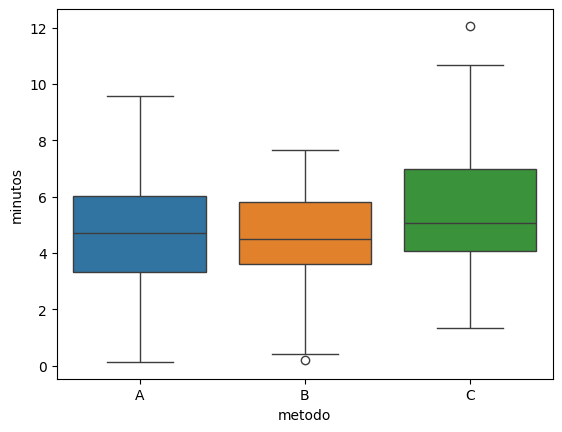

In [84]:
sns.boxplot(df, x="metodo", y="minutos", hue="metodo")

Viendo los datos más en detalle:

In [85]:
for categoria in df["metodo"].unique():
        dataframe_filtrado = df[df["metodo"] == categoria]
    
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe().T)

Los principales estadísticos de las columnas categóricas para el A son: 


,count,mean,std,min,25%,50%,75%,max
minutos,50.0,4.720512,2.102454,0.130465,3.312806,4.690071,6.005251,9.584416


Los principales estadísticos de las columnas categóricas para el B son: 


,count,mean,std,min,25%,50%,75%,max
minutos,50.0,4.404768,1.997027,0.187206,3.597334,4.506685,5.825817,7.668974


Los principales estadísticos de las columnas categóricas para el C son: 


,count,mean,std,min,25%,50%,75%,max
minutos,50.0,5.600274,2.329937,1.334696,4.071824,5.064969,6.976655,12.059491


Podemos observar que tanto la media como la mediana del grupo B es mejor, además tiene el mínimo y el máximo más bajo. Por lo que respalda nuestra idea de que el grupo B sería el más óptimo.

#### Ejercicio 2: Densidad de Fluidos 


La convección es un mecanismo fundamental de transferencia de calor en fluidos, que ocurre debido a las variaciones en la densidad provocadas por diferencias de temperatura. Este fenómeno se manifiesta cuando las porciones del fluido que se calientan, al volverse menos densas, ascienden hacia regiones de menor temperatura, mientras que las porciones más frías, al ser más densas, descienden hacia las zonas donde la temperatura es más alta. Este movimiento continuo da lugar a las llamadas corrientes de convección, las cuales desempeñan un papel crucial en la distribución homogénea de la temperatura dentro del fluido, promoviendo un equilibrio térmico.

En este contexto, se ha diseñado y ejecutado un experimento con el propósito de investigar cómo se ve afectada la densidad de un fluido cuando se incrementa la temperatura en una región específica del sistema; por tanto se asegura la independencia y aleatoriedad del mismo. El objetivo del experimento es comprender en detalle las modificaciones en la densidad que resultan de este aumento térmico y cómo estas afectan el comportamiento global del fluido.


1. Analiza las suposiciones del modelo: ¿Se cumplen las condiciones de homocedasticidad, independencia y normalidad?
2. ¿Tiene la temperatura un impacto notable en la densidad del fluido?
3. ¿Es posible concluir que las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175?

In [86]:
df_fluidos = pd.read_csv("../datos/densidad_fluidos.csv")
df_fluidos

,temperatura,densidad
0,100,21.790655
1,100,21.725900
2,100,21.806052
3,100,21.895319
4,100,21.716121
...,...,...
395,175,21.829916
396,175,21.670612
397,175,22.063380
398,175,21.875332


Hagamos una pequeña exploración:

In [87]:

print(f"El número de datos es {df_fluidos.shape[0]} y el de columnas es {df_fluidos.shape[1]}")
print(f"Los duplicados que tenemos en el conjunto de datos son: {df_fluidos.duplicated().sum()}")


print(f"\nLos tipos de las columnas son:")
display(pd.DataFrame(df_fluidos.dtypes, columns = ["tipo_dato"]))

df_fluidos.describe().T

El número de datos es 400 y el de columnas es 2
Los duplicados que tenemos en el conjunto de datos son: 0

Los tipos de las columnas son:


,tipo_dato
temperatura,int64
densidad,float64


,count,mean,std,min,25%,50%,75%,max
temperatura,400.0,137.500000,27.985854,100.000000,118.75000,137.500000,156.250000,175.000000
densidad,400.0,21.733028,0.169214,21.323342,21.61463,21.742521,21.843457,22.170432


In [88]:
df_fluidos["temperatura"].unique()

array([100, 125, 150, 175])

Observamos que la densidad no tiene un rango nada amplio, su valor mínimo es 21.32 y su valor máximo es 22.17

Veamos si cumple las asunciones para poder aplicar un test paramétrico.

### Normalidad

Como tenemos más de 30 datos usaremos la Kolmogorov.

In [89]:
# Kolmogorov test
np.random.seed(42)

def calculo_kolmogorov(df, grupo, columna):
    datos = df.groupby(grupo)[columna].agg(["mean", "std"])
    datos
    lista_grupos = list(df[grupo].unique())

    for i in range(datos.shape[0]):
        dist = np.random.normal(loc=datos.iloc[i,0], scale = datos.iloc[i,1], size = df.shape[0])
        res = stats.kstest(df[df[grupo]==lista_grupos[i]][columna], dist) #Quiero que me diga si es normal o no
        print(f"Kolmogorov del grupo {lista_grupos[i]}: {res}")

calculo_kolmogorov(df_fluidos, "temperatura", "densidad")

Kolmogorov del grupo 100: KstestResult(statistic=np.float64(0.0475), pvalue=np.float64(0.9916523423030328), statistic_location=np.float64(21.82235226299658), statistic_sign=np.int8(-1))
Kolmogorov del grupo 125: KstestResult(statistic=np.float64(0.07), pvalue=np.float64(0.8131232081337524), statistic_location=np.float64(21.545675010423196), statistic_sign=np.int8(-1))
Kolmogorov del grupo 150: KstestResult(statistic=np.float64(0.0975), pvalue=np.float64(0.41724457668774784), statistic_location=np.float64(21.87861989339484), statistic_sign=np.int8(1))
Kolmogorov del grupo 175: KstestResult(statistic=np.float64(0.0575), pvalue=np.float64(0.946417904256311), statistic_location=np.float64(21.81826182408329), statistic_sign=np.int8(1))


Como todos los p-values son mayores que 0.05 entonces todos los grupos tienen una distribución normal y podemos continuar comprobando la homoceidad.

### Homoceidad

Veamos si tenemos que aplicar Levene o Barlett.

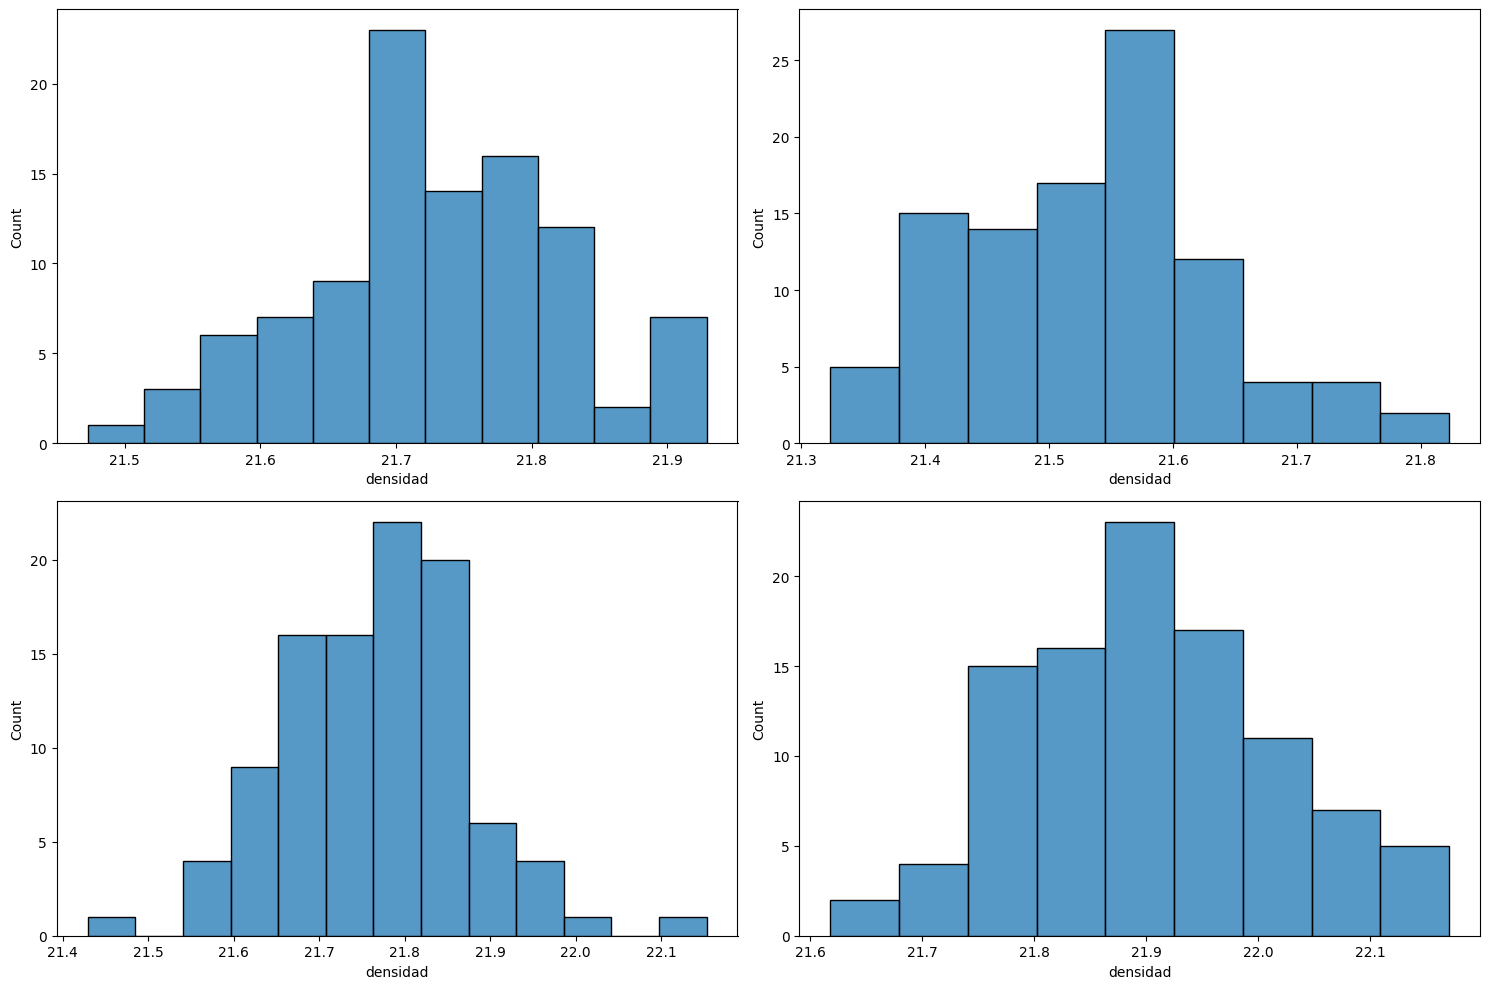

In [96]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
axes= axes.flat

lista_temperaturas = list(df_fluidos["temperatura"].unique())
lista_temperaturas = [int(elem) for elem in lista_temperaturas]
lista_temperaturas

for i,temp in enumerate(lista_temperaturas):
    sns.histplot(df_fluidos[df_fluidos["temperatura"]==temp], x ="densidad", ax=axes[i])

plt.tight_layout()  # Ajustar el layout para que no se solapen
plt.show()


Como podemos observar las gráficas se aproximana una normal pero no es una normal perfecta por lo que usaremos Levene.

In [91]:
def calcular_levene(df, columna_grupos, columna_metrica):
    unicos = df[columna_grupos].unique()

    for grupo in unicos:
        df_metrica = df[df[columna_grupos] == grupo][columna_metrica]
        globals()[grupo] = df_metrica
    
    print(stats.levene(*[globals()[var] for var in unicos]))

calcular_levene(df_fluidos, "temperatura", "densidad")

LeveneResult(statistic=np.float64(1.3647908525254946), pvalue=np.float64(0.25311302633232835))


El p-valor al ser 0.25 > 0.05 confirma la homoceidad.

Como las temperaturas y la densidad para cada una son independientes unas de otras podemos aplicar un test paramétrico. En este caso al tener 4 grupos aplicaremos un Anova.

In [121]:
def calcular_anova(df, columna_grupos, columna_metrica):
    unicos = df[columna_grupos].unique()

    for grupo in unicos:
        df_metrica = df[df[columna_grupos] == grupo][columna_metrica]
        globals()[grupo] = df_metrica
    
    print(stats.f_oneway(*[globals()[var] for var in unicos]))

calcular_anova(df_fluidos, "temperatura", "densidad")

F_onewayResult(statistic=np.float64(212.84277610615817), pvalue=np.float64(3.327798065119595e-82))


El p-valor al ser mayor que 0.05 indica que sí que hay una diferencia significativa entre los grupos.

Veamos si las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175


In [101]:
df_A = pd.concat([df_fluidos[df_fluidos["temperatura"]==100], df_fluidos[df_fluidos["temperatura"]==125]])
df_B = pd.concat([df_fluidos[df_fluidos["temperatura"]==150], df_fluidos[df_fluidos["temperatura"]==175]])

In [105]:
df_A["temperatura"]="grupoA"
df_B["temperatura"]="grupoB"
df_total = pd.concat([df_A, df_B])

<Axes: xlabel='temperatura', ylabel='densidad'>

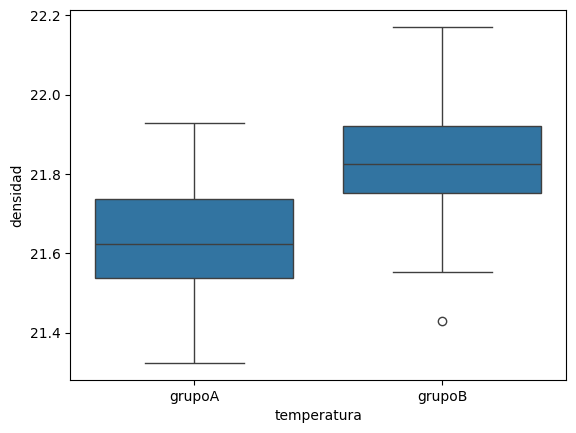

In [108]:
sns.boxplot(df_total, x="temperatura", y="densidad")

In [113]:
display(df_A.describe().T)
display(df_B.describe().T)


,count,mean,std,min,25%,50%,75%,max
densidad,200.0,21.630906,0.138807,21.323342,21.537102,21.622429,21.736916,21.928896


,count,mean,std,min,25%,50%,75%,max
densidad,200.0,21.83515,0.131073,21.429454,21.752522,21.825754,21.920089,22.170432


Nuentra hipotesis es que las temperaturas 100 y 125 provocan en promedio una menor densidad en el fluido comparadas con las temperaturas de 150 y 170. Sin embargo haremos un test para estar totalmente seguros de que las diferencias son significativas.

- Normalidad

Como tenemos 400 datos usaremos una Kolmogorov.

In [110]:
calculo_kolmogorov(df_total, "temperatura", "densidad")

Kolmogorov del grupo grupoA: KstestResult(statistic=np.float64(0.0875), pvalue=np.float64(0.25438687552104255), statistic_location=np.float64(21.5624776427124), statistic_sign=np.int8(1))
Kolmogorov del grupo grupoB: KstestResult(statistic=np.float64(0.0425), pvalue=np.float64(0.9672282978991504), statistic_location=np.float64(21.95214582968895), statistic_sign=np.int8(-1))


Como todos los p-values son mayores que 0.05 entonces todos los grupos tienen una distribución normal y podemos continuar comprobando la homoceidad.

- Homoceidad

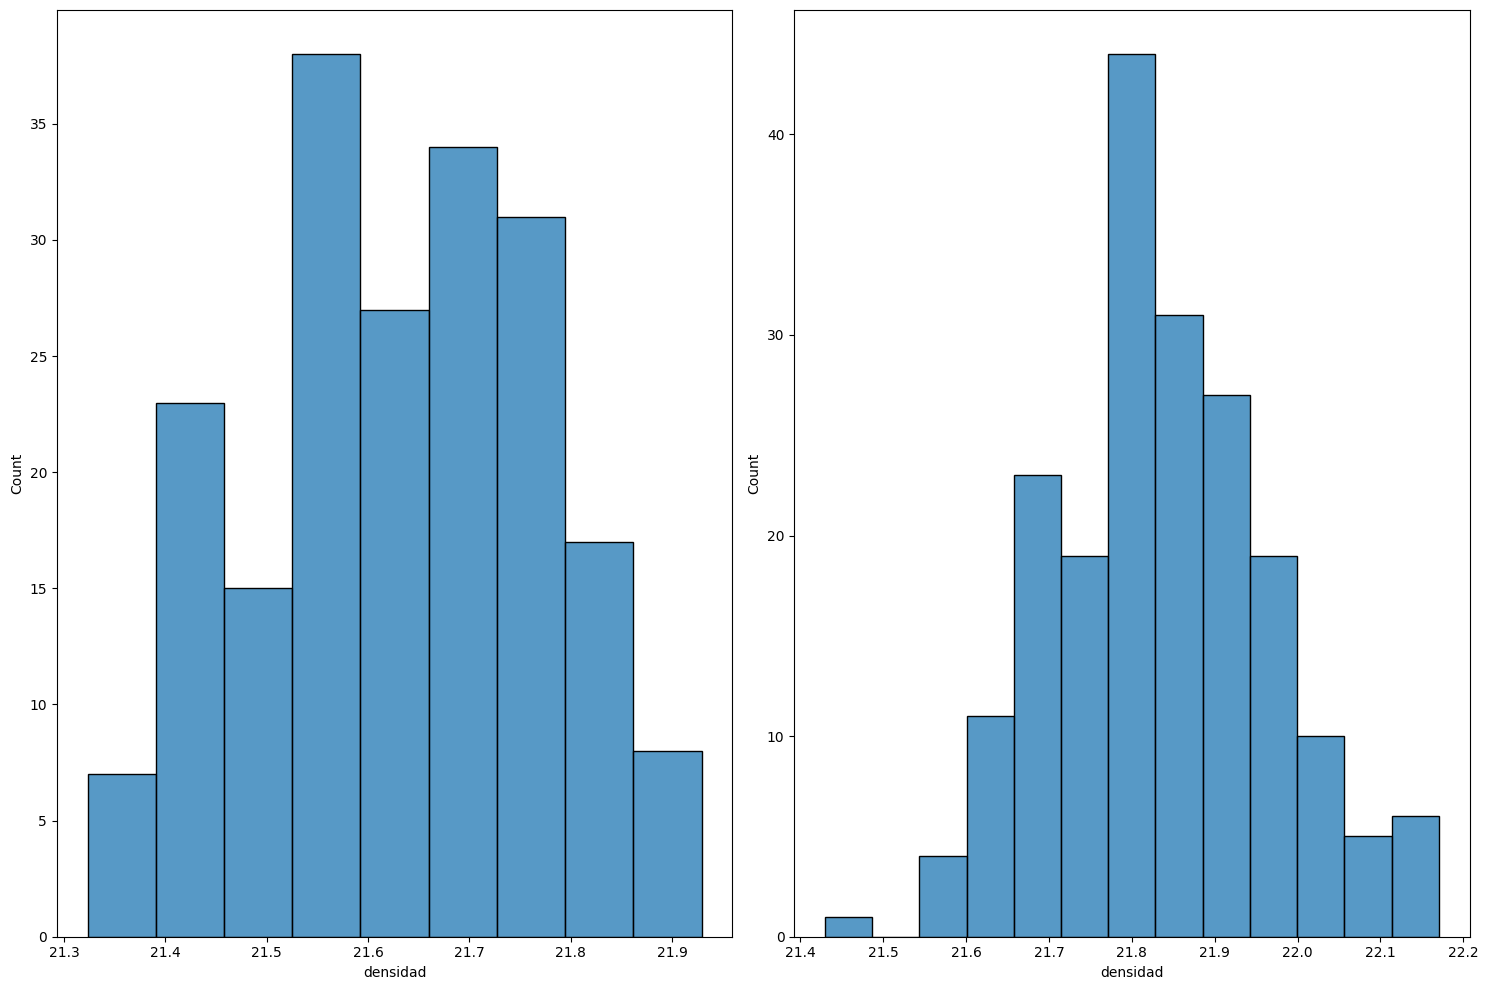

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(15,10))
axes= axes.flat

lista_temperaturas = list(df_total["temperatura"].unique())
lista_temperaturas

for i,temp in enumerate(lista_temperaturas):
    sns.histplot(df_total[df_total["temperatura"]==temp], x ="densidad", ax=axes[i])

plt.tight_layout()  # Ajustar el layout para que no se solapen
plt.show()

Como podemos observar las gráficas se aproximana una normal pero no es una normal perfecta por lo que usaremos Levene.

In [119]:
calcular_levene(df_total, "temperatura", "densidad")

LeveneResult(statistic=np.float64(3.28938013245296), pvalue=np.float64(0.07048233198305964))


El p-valor al ser 0.07 > 0.05 confirma la homoceidad.

Como las temperaturas y la densidad para cada una son independientes unas de otras podemos aplicar un test paramétrico. En este caso al tener 2 grupos aplicaremos un t-student.

In [122]:
def calcular_anova(df, columna_grupos, columna_metrica):
    unicos = df[columna_grupos].unique()

    for grupo in unicos:
        df_metrica = df[df[columna_grupos] == grupo][columna_metrica]
        globals()[grupo] = df_metrica
    
    print(stats.ttest_ind(*[globals()[var] for var in unicos]))

calcular_anova(df_total, "temperatura", "densidad")

TtestResult(statistic=np.float64(-15.129677894969593), pvalue=np.float64(3.563849634924047e-41), df=np.float64(398.0))


Como el p-valor es menor que 0.05 entonces de acepta H1, es decir, sí que hay una diferencia significativa entre los grupos. Y al ser menor la media del grupo A entonces las temperaturas de 100 y 125 provocan en promedio una menor densidad en el fluido comparadas con las temperaturas de 150 y 175.